In [74]:
from itertools import product
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import f1_score


In [86]:
# Load and preprocess data
datas = pd.read_csv('MSFT.csv')
datas.columns = datas.columns.str.strip()
datas['Date'] = datas['Date'].astype('datetime64[ns]')
datas = datas.sort_values('Date')

In [88]:
# Feature engineering

datas['short_ema'] = datas['Close'].ewm(span=12, adjust=False).mean()
datas['long_ema'] = datas['Close'].ewm(span=26, adjust=False).mean()


def calculate_rsi(datas, window):
    delta = datas['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

datas['rsi'] = calculate_rsi(datas, 14)

# Signals based on EMA crossover and RSI filtering
datas['signal'] = np.where((datas['short_ema'] > datas['long_ema']) & (datas['rsi'] < 70), 1.0, 
                           np.where((datas['short_ema'] < datas['long_ema']) & (datas['rsi'] > 30), 0.0, np.nan))

# Forward-fill the signals to handle NaN values 
datas['signal'] = datas['signal'].ffill().fillna(0)

def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA

datas['EMA21'] = EMA(datas, 21)
datas['EMA63'] = EMA(datas, 63)
datas['EMA252'] = EMA(datas, 252)

def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name='ROC_' + str(n))
    return ROC

datas['ROC21'] = ROC(datas['Close'], 21)
datas['ROC63'] = ROC(datas['Close'], 63)

def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM

datas['MOM21'] = MOM(datas['Close'], 21)
datas['MOM63'] = MOM(datas['Close'], 63)

def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean(u[:period])
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean(d[:period])
    d = d.drop(d.index[:(period-1)])
    rs = u.rolling(period-1).mean() / d.rolling(period-1).mean()
    return 100 - 100 / (1 + rs)

datas['RSI21'] = RSI(datas['Close'], 21)
datas['RSI63'] = RSI(datas['Close'], 63)
datas['RSI252'] = RSI(datas['Close'], 252)

def STOK(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

datas['%K21'] = STOK(datas['Close'], datas['Low'], datas['High'], 21)
datas['%D21'] = STOD(datas['Close'], datas['Low'], datas['High'], 21)
datas['%K63'] = STOK(datas['Close'], datas['Low'], datas['High'], 63)
datas['%D63'] = STOD(datas['Close'], datas['Low'], datas['High'], 63)
datas['%K252'] = STOK(datas['Close'], datas['Low'], datas['High'], 252)
datas['%D252'] = STOD(datas['Close'], datas['Low'], datas['High'], 252)

def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA

datas['MA21'] = MA(datas, 21)
datas['MA63'] = MA(datas, 63)
datas['MA252'] = MA(datas, 252)
datas.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,short_ema,long_ema,rsi,...,RSI252,%K21,%D21,%K63,%D63,%K252,%D252,MA21,MA63,MA252
2602,2024-07-05,459.609985,468.350006,458.970001,467.559998,467.559998,16000300,453.363179,443.630575,77.439845,...,56.779363,98.482214,99.127823,99.016424,99.413571,99.502827,99.710472,444.916668,424.859206,379.801390
2603,2024-07-08,466.549988,467.700012,464.459991,466.239990,466.239990,12962300,455.344227,445.305347,74.826956,...,56.946270,95.582970,97.859411,97.372988,98.682300,98.672111,99.336666,446.927620,425.505556,380.297302
2604,2024-07-09,467.000000,467.329987,458.000000,459.540009,459.540009,17207200,455.989732,446.359766,61.498901,...,56.866058,80.573328,91.546171,89.031379,95.140264,94.455634,97.543524,448.595240,426.060318,380.782699
2605,2024-07-10,461.220001,466.459991,458.859985,466.250000,466.250000,18174600,457.568235,447.833117,68.694871,...,57.145759,95.276639,90.477646,97.385451,94.596606,98.678410,97.268718,450.614287,426.694762,381.316112
2606,2024-07-11,462.730011,464.779999,451.549988,452.029999,452.029999,9129230,456.716198,448.143997,54.735892,...,56.072000,62.134560,79.328175,79.681268,88.699366,89.729385,94.287810,451.764763,427.151429,381.790556


In [90]:
# Data preparation
datasubs = datas.drop(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open','Volume', 'short_ema', 'long_ema'], axis=1)
datasubs = datasubs.dropna()
X = datasubs.drop(['signal'], axis=1)
y = datasubs['signal']
train_size = int(len(datasubs) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Standardize data
rs = RobustScaler()
X_train_std = rs.fit_transform(X_train)
X_test_std = rs.transform(X_test)

Cross-validation accuracy: 0.9248120300751879 (0.05099496227913736)
test f1: 0.9208997121350284 train f1: 0.9030365152954231


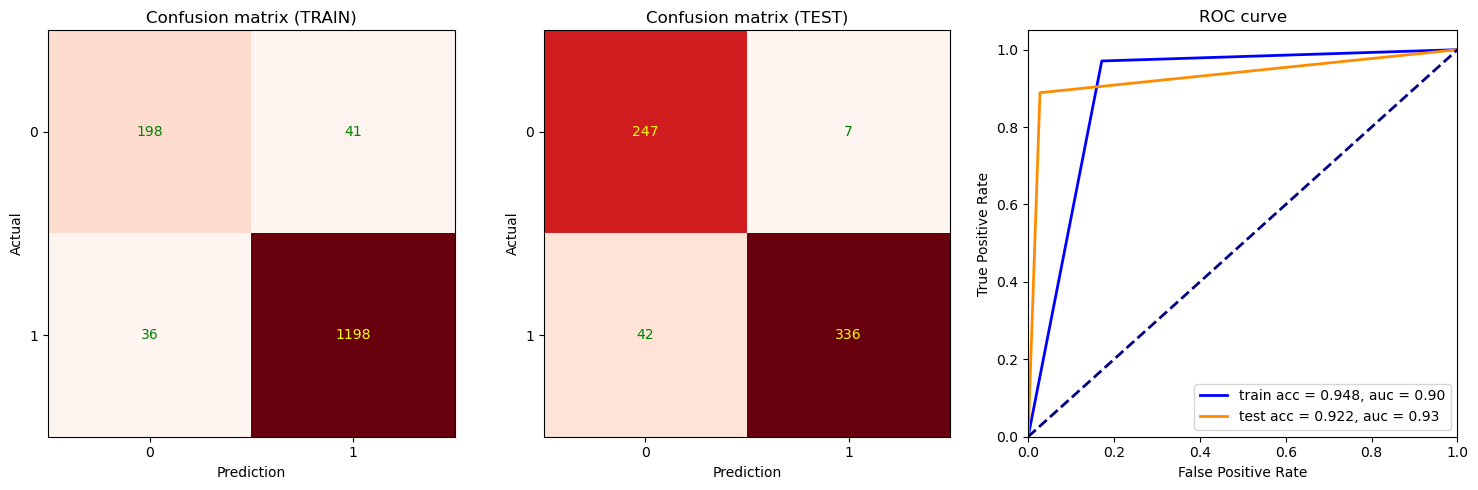

In [92]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import f1_score

# Confusion matrix
def pltcm(ax, y_true, y_pred, labels, title, threshold):
    cm = confusion_matrix(y_true, (y_pred > threshold).astype(int), labels=labels)
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    ax.set_title(title)
    tick_marks = np.arange(len(labels))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Prediction')
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="yellow" if cm[i, j] > thresh else "green")

# Function to plot the ROC curve
def pltauc(ax, y_train_true, y_train_pred, y_test_true, y_test_pred, threshold):
    fpr_train, tpr_train, _ = roc_curve(y_train_true, (y_train_pred > threshold).astype(int))
    fpr_test, tpr_test, _ = roc_curve(y_test_true, (y_test_pred > threshold).astype(int))
    roc_auc_train = roc_auc_score(y_train_true, (y_train_pred > threshold).astype(int))
    roc_auc_test = roc_auc_score(y_test_true, (y_test_pred > threshold).astype(int))
    ax.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'train acc = {accuracy_score(y_train_true, (y_train_pred > threshold).astype(int)):.3f}, auc = {roc_auc_train:.2f}')
    ax.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'test acc = {accuracy_score(y_test_true, (y_test_pred > threshold).astype(int)):.3f}, auc = {roc_auc_test:.2f}')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    ax.legend(loc="lower right")

# F1 score
def btf1(model, X, y, average='macro'):
    y_proba = model.predict_proba(X)[:, 1]
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_threshold = 0.0
    best_f1 = 0.0

    for threshold in thresholds:
        y_pred = (y_proba > threshold).astype(int)
        f1 = f1_score(y, y_pred, average=average)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1


def testf1(model, threshold, X_test, y_test, average='macro'):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba > threshold).astype(int)
    return f1_score(y_test, y_pred, average=average)


rf = RandomForestClassifier(
    n_estimators=100,      
    max_depth=3,           
    min_samples_split=20,  
    min_samples_leaf=10,    
    random_state=42
)


tscv = TimeSeriesSplit(n_splits=10)
cv_results = cross_val_score(rf, X_train_std, y_train, cv=tscv, scoring='accuracy')

print(f"Cross-validation accuracy: {cv_results.mean()} ({cv_results.std()})")

# Fit the model on the training data
rf.fit(X_train_std, y_train)

bestthreshold, bestf1 = btf1(rf, X_train_std, y_train, average='macro')

# test F1 score
testf1_score = testf1(rf, bestthreshold, X_test_std, y_test, average='macro')
print('test f1:', testf1_score, 'train f1:', bestf1)

# Plotting the results
def result(es, threshold, X_train, X_test, y_train, y_test):
    y_train_pred = es.predict_proba(X_train)[:, 1]
    y_test_pred = es.predict_proba(X_test)[:, 1]
    
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 5)
    pltcm(ax[0], y_train, y_train_pred, [0, 1], 'Confusion matrix (TRAIN)', threshold)
    pltcm(ax[1], y_test, y_test_pred, [0, 1], 'Confusion matrix (TEST)', threshold)
    pltauc(ax[2], y_train, y_train_pred, y_test, y_test_pred, threshold)
    plt.tight_layout()
    plt.show()

result(rf, bestthreshold, X_train_std, X_test_std, y_train, y_test)

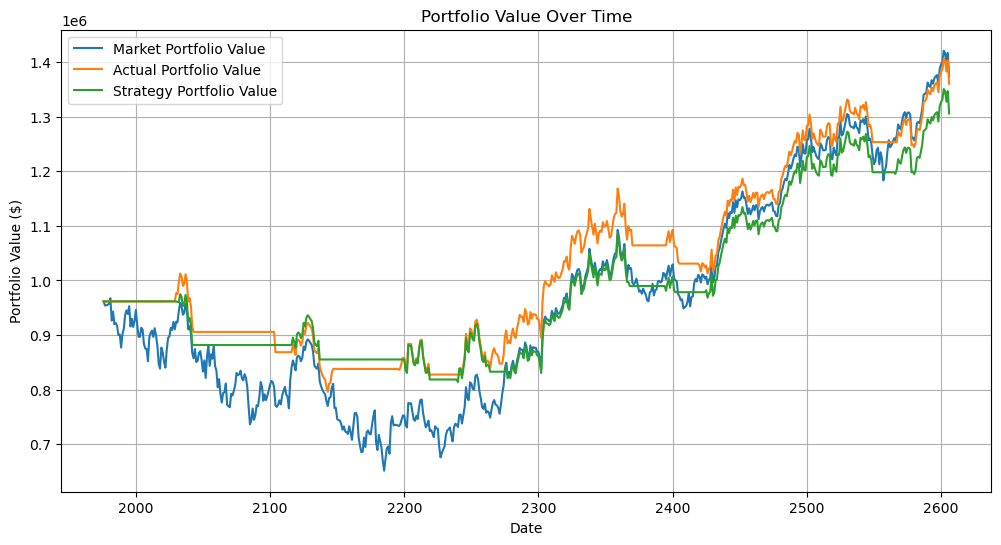

           Close  Market Returns  Actual Returns  Strategy Returns  \
1975  329.010010             NaN             NaN               NaN   
1976  316.380005       -0.038388       -0.038388         -0.038388   
1977  313.880005       -0.007902       -0.000000         -0.000000   
1978  314.040009        0.000510        0.000000          0.000000   
1979  314.269989        0.000732        0.000000          0.000000   

      Portfolio Value (Market)  Portfolio Value (Actual)  \
1975                       NaN                       NaN   
1976             961612.095024             961612.095024   
1977             954013.542020             961612.095024   
1978             954499.861570             961612.095024   
1979             955198.867658             961612.095024   

      Portfolio Value (Strategy)  
1975                         NaN  
1976               961612.095024  
1977               961612.095024  
1978               961612.095024  
1979               961612.095024  


In [94]:

y_test_proba = rf.predict_proba(X_test_std)[:, 1]
y_test_pred_class = (y_test_proba > bestthreshold).astype(int)

# Create DataFrame for backtesting
backtestdata = pd.DataFrame(index=X_test.index)
backtestdata['signal_pred'] = y_test_pred_class
backtestdata['signal_actual'] = y_test.values

# Add 'Close' prices to the backtest data
backtestdata['Close'] = datas.loc[backtestdata.index, 'Close']

# Market Returns
backtestdata['Market Returns'] = backtestdata['Close'].pct_change()

# Actual Returns and Strategy Returns
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)

initial_investment = 1000000  

# Calculate cumulative returns
backtestdata['Cumulative Market Returns'] = (1 + backtestdata['Market Returns']).cumprod()
backtestdata['Cumulative Actual Returns'] = (1 + backtestdata['Actual Returns']).cumprod()
backtestdata['Cumulative Strategy Returns'] = (1 + backtestdata['Strategy Returns']).cumprod()

# Calculate portfolio value
backtestdata['Portfolio Value (Market)'] = initial_investment * backtestdata['Cumulative Market Returns']
backtestdata['Portfolio Value (Actual)'] = initial_investment * backtestdata['Cumulative Actual Returns']
backtestdata['Portfolio Value (Strategy)'] = initial_investment * backtestdata['Cumulative Strategy Returns']

# Plot
plt.figure(figsize=(12, 6))
plt.plot(backtestdata.index, backtestdata['Portfolio Value (Market)'], label='Market Portfolio Value')
plt.plot(backtestdata.index, backtestdata['Portfolio Value (Actual)'], label='Actual Portfolio Value')
plt.plot(backtestdata.index, backtestdata['Portfolio Value (Strategy)'], label='Strategy Portfolio Value')
plt.legend()
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.show()


print(backtestdata[['Close', 'Market Returns', 'Actual Returns', 'Strategy Returns', 'Portfolio Value (Market)', 'Portfolio Value (Actual)', 'Portfolio Value (Strategy)']].head())